In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

OUTPUT_CHANNELS = 3

In [2]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 

  w = tf.shape(image)[1]
  w = w // 2
  satellite_image = image[:, w:, :]
  aerial_image = image[:, :w, :]

  # Convert both images to float32 tensors
  satellite_image = tf.cast(satellite_image, tf.float32)
  aerial_image = tf.cast(aerial_image, tf.float32)

  return aerial_image, satellite_image

In [3]:
BUFFER_SIZE = 400

BATCH_SIZE = 1

IMG_HEIGHT = 256
IMG_WIDTH = 256

In [4]:
def resize(input_img, real_img, height, width):
    input_img = tf.image.resize(input_img, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_img = tf.image.resize(real_img, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_img, real_img

In [5]:
def random_crop(input_img, real_img):
    stacked_img = tf.stack([input_img, real_img], axis=0)
    cropped_img = tf.image.random_crop(stacked_img, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_img[0], cropped_img[1]

In [6]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [7]:
@tf.function()
def random_jitter(input_img, real_img):
    #resize
    input_img, real_img = resize(input_img, real_img, 286, 286)

    #randome crop to 256
    input_img, real_img = random_crop(input_img, real_img)

    if tf.random.uniform(()) > 0.5:
        #random mirror
        input_img = tf.image.flip_left_right(input_img)
        real_img = tf.image.flip_left_right(real_img)
    
    return input_img, real_img

In [8]:
def load_image_test(image_file):
  input_image, real_image= load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [9]:
def load_image_train(image_file):
  input_image, real_image= load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [10]:
def downsample(filters, size, apply_batchnorm=True, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [11]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [12]:
def _Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [13]:
def Generator():
  ## revert the dropput - pix2pix  - street to real 
  ## move kernal size to 9
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  k_size = 9

  down_stack = [
    downsample(64, k_size, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, k_size),  # (batch_size, 64, 64, 128)
    downsample(256, k_size),  # (batch_size, 32, 32, 256)
    downsample(512, k_size, apply_dropout=True),  # (batch_size, 16, 16, 512)
    downsample(512, k_size),  # (batch_size, 8, 8, 512)
    downsample(512, k_size, apply_dropout=True),  # (batch_size, 4, 4, 512)
    downsample(512, k_size, apply_dropout=True),  # (batch_size, 2, 2, 512)
    downsample(512, k_size, apply_dropout=True),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, k_size),  # (batch_size, 2, 2, 1024)
    upsample(512, k_size),  # (batch_size, 4, 4, 1024)
    upsample(512, k_size),  # (batch_size, 8, 8, 1024)
    upsample(512, k_size),  # (batch_size, 16, 16, 1024)
    upsample(256, k_size),  # (batch_size, 32, 32, 512)
    upsample(128, k_size),  # (batch_size, 64, 64, 256)
    upsample(64, k_size),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [14]:
generator = Generator()
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [15]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)
  k_size = 9
  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, k_size, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, k_size)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, k_size)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, k_size, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, k_size, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [16]:
discriminator = Discriminator()
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def discriminator_loss(disc_real_output, disc_generated_output):

  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss


In [18]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [19]:
test_path = "../DataBackUp/merge16/validate"
#test_path = "../DataBackUp/merge/validate"
checkpoint_dir = '../checkpoint/v15'

test_dataset = tf.data.Dataset.list_files(str(test_path + '/*.jpeg'))
test_dataset = test_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#checkpoint_dir = './checkpoint/v1'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [20]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  disc_real_output = discriminator([test_input, tar], training=True)
  disc_generated_output = discriminator([test_input, prediction], training=True)
  disc_loss = discriminator_loss(disc_real_output, disc_generated_output)


  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

tf.Tensor(0.117869124, shape=(), dtype=float32)


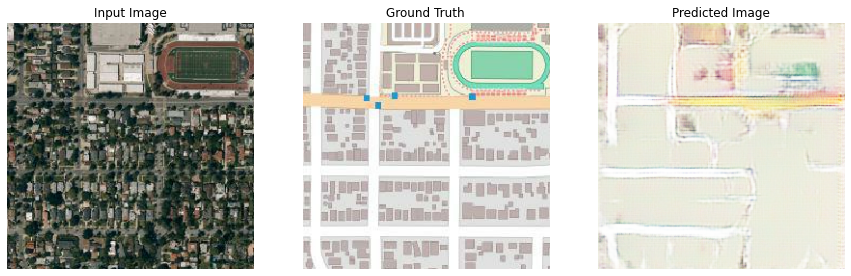

tf.Tensor(0.31944415, shape=(), dtype=float32)


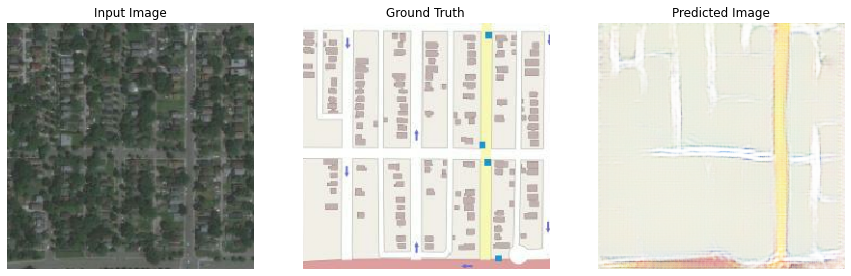

tf.Tensor(0.15160309, shape=(), dtype=float32)


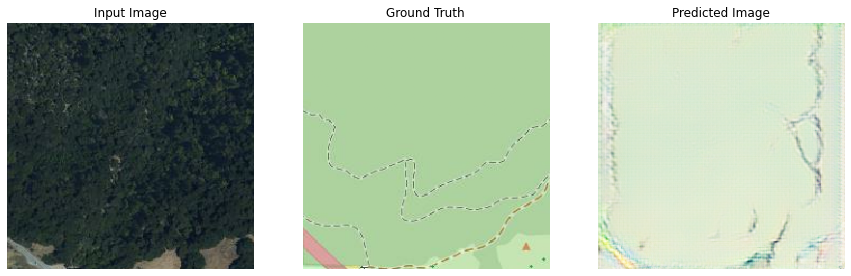

tf.Tensor(0.16040844, shape=(), dtype=float32)


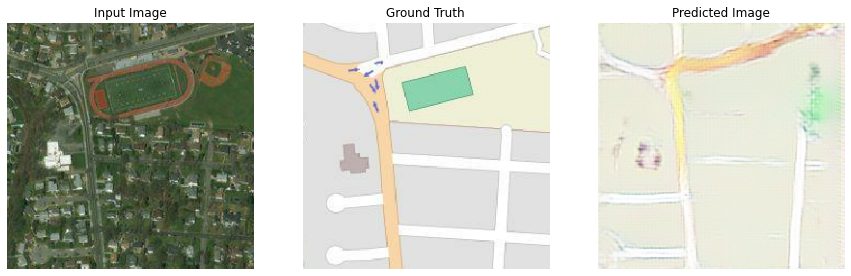

tf.Tensor(1.1383744, shape=(), dtype=float32)


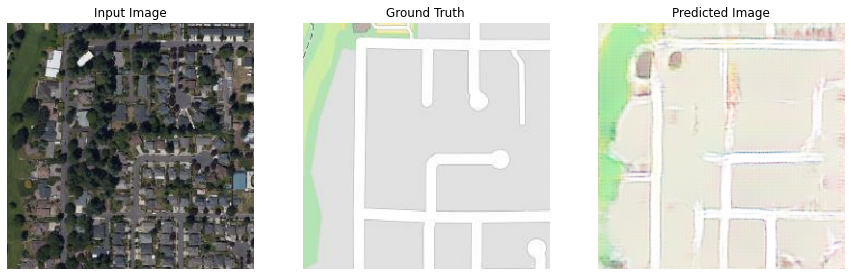

tf.Tensor(0.081697315, shape=(), dtype=float32)


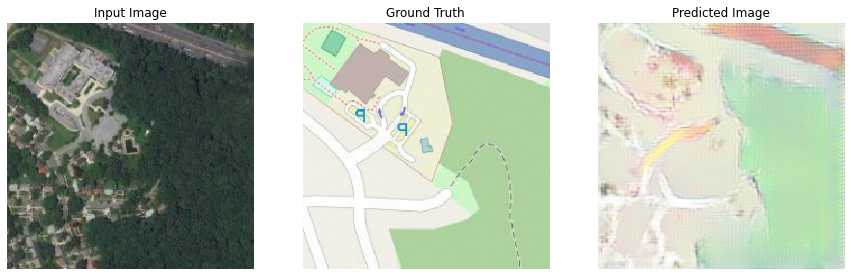

tf.Tensor(0.72231764, shape=(), dtype=float32)


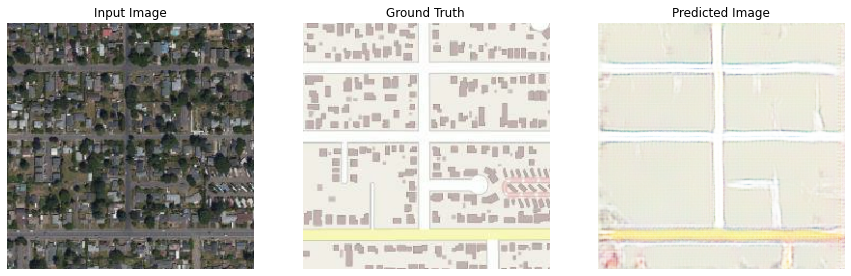

tf.Tensor(1.0065215, shape=(), dtype=float32)


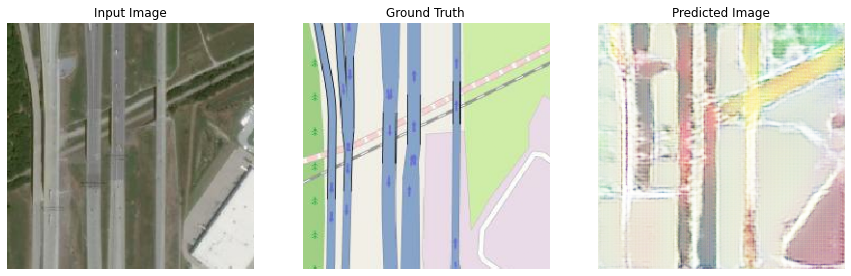

tf.Tensor(0.23001121, shape=(), dtype=float32)


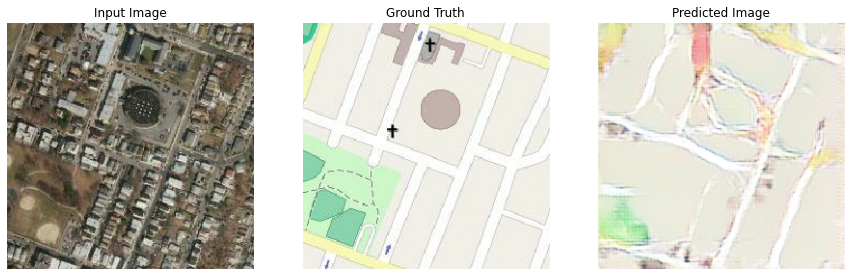

tf.Tensor(0.22072789, shape=(), dtype=float32)


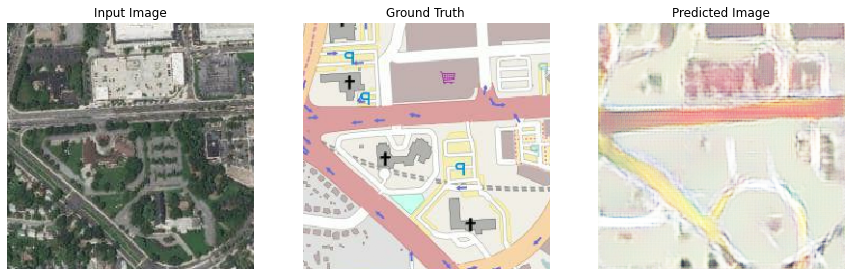

In [21]:
for example_input, example_target in test_dataset.take(10):
  generate_images(generator, example_input, example_target)

In [22]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [23]:
for example_input, example_target in test_dataset[0:5]:
  generate_images(generator, example_input, example_target)

TypeError: 'BatchDataset' object is not subscriptable